This notebook loads the 4 run-to-failure MOSFET tests #09, #11, #12 and #36 of NASA's MOSFET dataset that contain the preprocessed values of the Delta-RDSon [1].

After loading the datasets, a Temporal Fusion Transformer (TFT) model is trained with the 100% of the samples of 2 complete tests and the TFT's ageing forecasting performance is evaluated using a 3rd test (leave one out) on different ageing forecasting horizons. Finally, it computes the obtained MAPE and plots the results.

Note: The results obtained were using the version 0.24.0 of Darts. Using a different version may affect the results.

[1] J. Celaya et al. "MOSFET Thermal Overstress Aging Data Set". In: NASA AMES Prognostics Data Repository (2007). URL: https://www.nasa.gov/intelligent-systems-division/discovery-and-systemshealth/pcoe/pcoe-data-set-repository/.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.explainability import TFTExplainer
import warnings
import time
from scipy.optimize import curve_fit

from pathlib import Path
warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Read data

In [3]:
# before starting, we define some constants
num_samples = 500 #samples per forecast
# default quantiles for QuantileRegression
quantiles = [0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99,]
#Figure Size
figsize = (9, 6)
#Percentiles for plotting
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [4]:
#Path to directory containing the csvs
DATAPATH = Path("./RDSon_CSVs/")
test11_df = pd.read_csv(DATAPATH / "Test_11_RDSon.csv", names=['rdson'])
test12_df = pd.read_csv(DATAPATH / "Test_12_RDSon.csv", names=['rdson'])
test09_df = pd.read_csv(DATAPATH / "Test_09_RDSon.csv", names=['rdson'])
test36_df = pd.read_csv(DATAPATH / "Test_36_RDSon.csv", names=['rdson'])
print("Test 11 shape: ",test11_df.shape)
print("Test 12 shape: ",test12_df.shape)
print("Test 09 shape: ",test09_df.shape)
print("Test 36 shape: ",test36_df.shape)

Test 11 shape:  (100, 1)
Test 12 shape:  (100, 1)
Test 09 shape:  (100, 1)
Test 36 shape:  (100, 1)


In [5]:
#convert Test DFs into TimeSeries
test11_series = TimeSeries.from_dataframe(test11_df)
test12_series = TimeSeries.from_dataframe(test12_df)
test09_series = TimeSeries.from_dataframe(test09_df)
test36_series = TimeSeries.from_dataframe(test36_df)

<Axes: xlabel='time'>

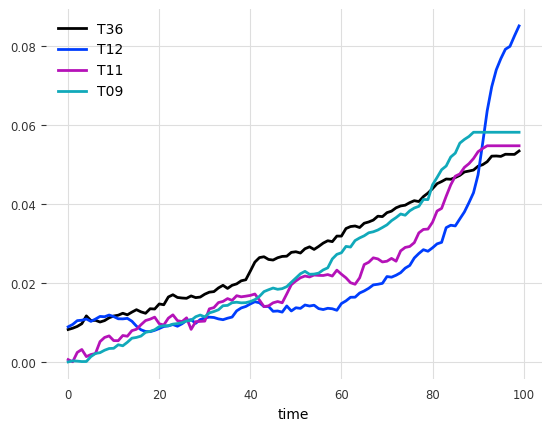

In [6]:
#Plot TS
test36_series.plot(label="T36")
test12_series.plot(label="T12")
test11_series.plot(label="T11")
test09_series.plot(label="T09")

In [7]:
# Normalize the time series
transformer_11, transformer_12, transformer_09, transformer_36 = Scaler(), Scaler(), Scaler(), Scaler()

test_09_transformed= transformer_09.fit_transform(test09_series)
test_09_transformed_trimmed = test_09_transformed[0:90] #Remove padding values

test_11_transformed= transformer_11.fit_transform(test11_series)
test_11_transformed_trimmed = test_11_transformed[0:93] #Remove padding values

test_12_transformed= transformer_12.fit_transform(test12_series)

test_36_transformed = transformer_36.fit_transform(test36_series)

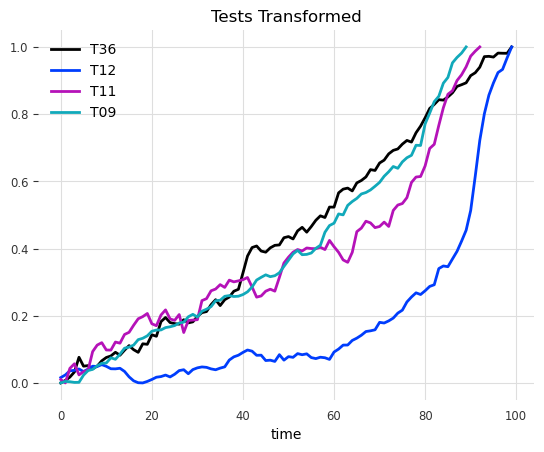

In [8]:
#Plot TS
test_36_transformed.plot(label="T36")
test_12_transformed.plot(label="T12")
test_11_transformed_trimmed.plot(label="T11")
test_09_transformed_trimmed.plot(label="T09")
plt.title("Tests Transformed")
plt.show()

# Auxilary functions

In [3]:
def pred_n_tr(model, split_point, fh, test_transformed, covs, verbose=True):
    #This function automates the process of training the TFT model with a portion of the TimeSeries and then increment the size
    #of the training portion by N steps predicted to then repeat the process for the entire length of the TimeSeries.
    #These are the inputs:
    #model: TFT model object, split_point: starting split point for the TimeSeries,
    #fh: number of steps ahead to predict, test_transformed: TimeSeries,
    #covs: covariates vector; verbose: flag used to control if the function shows the progress or not
    start_time = time.time()
    for k in range(split_point, len(test_transformed)-1, fh):
        test_transformed_train, test_transformed_val = test_transformed.split_after(k) 
        if verbose: print("k={}, train={}, val={}".format(k,len(test_transformed_train),len(test_transformed_val)))
        model.fit(test_transformed_train,
                  future_covariates=covs,
                  verbose=False)
        #predict N steps
        pred_cov = model.predict(n=fh,
                                 #future_covariates=covs,
                                 num_samples=num_samples, verbose=False)

        #save predictions in list
        if fh == 1:
            if k == split_point:
                predictions = pred_cov.copy()
            else:
                predictions = predictions.concatenate(pred_cov)
        else:
            if k == split_point:
                predictions = pred_cov.copy()
            else:
                predictions = predictions.append(pred_cov)



    end_time = time.time()
    elapsed_time = end_time - start_time
    print("--------------------------------------------------------------------")
    print("Elapsed time = {:.0f} minutes".format(elapsed_time / 60))
    print("Len predictions: {}".format(len(predictions)))
    return predictions

# Covariate creation

The covariate is a linear increase vector.

In [10]:
# create integer index covariate series
example_RI = pd.RangeIndex(start=0, stop=110, step=1)
covariates = TimeSeries.from_times_and_values(
    times=example_RI,
    values=np.arange(len(example_RI)),
    columns=["linear_increase"],
).astype(np.float32)

# transform covariates
scaler_covs = Scaler()
covariates_transformed = scaler_covs.fit_transform(covariates)

# Hyperparameters definition 

In [7]:
input_chunk_length = 20 #number of past values used to generate the prediction
forecast_horizon = 4 #steps ahead in the prediction, this has to be changed to 1, 2 or 4 depending on the selected case.
# For short-term, Model Architecture G is used (Table 2), see hyperparameter selection in the paper 
lstms = 1
attn_heads = 4
hiddenSize = 64

# Test #36

In [29]:
#start_time = time.time()
SELECTOR = 1
if SELECTOR == 1:
    test_A_transformed = test_36_transformed
    transformer_A = transformer_36
    test_No = "36"
elif SELECTOR == 2:
    test_A_transformed = test_12_transformed
    transformer_A = transformer_12
    test_No = "12"
elif SELECTOR == 3:
    test_A_transformed = test_11_transformed
    test_A_transformed_trimmed = test_11_transformed_trimmed
    transformer_A = transformer_11
    test_No = "11"
else:
    test_A_transformed = test_09_transformed
    test_A_transformed_trimmed = test_09_transformed_trimmed
    transformer_A = transformer_09
    test_No = "09"
print(test_No)

36


## Forecasting using the 33% of the data as training (Table 3 in the paper)

In [30]:
#Define the TFT
# input_chunk_length = 20
# forecast_horizon = 4
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 32
predictions_33 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=32, train=33, val=67
k=36, train=37, val=63
k=40, train=41, val=59
k=44, train=45, val=55
k=48, train=49, val=51
k=52, train=53, val=47
k=56, train=57, val=43
k=60, train=61, val=39
k=64, train=65, val=35
k=68, train=69, val=31
k=72, train=73, val=27
k=76, train=77, val=23
k=80, train=81, val=19
k=84, train=85, val=15
k=88, train=89, val=11
k=92, train=93, val=7
k=96, train=97, val=3
--------------------------------------------------------------------
Elapsed time = 17 minutes
Len predictions: 68


In [31]:
#Now the MAPE is computed for the mean, lower and upper quantiles
_, validation_series = test_A_transformed.split_after(training_cutoff)
MAPE_33 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_33))
pred33_q25 = predictions_33[0:len(validation_series)].quantile(0.025)
pred33_q975 = predictions_33[0:len(validation_series)].quantile(0.975)
MAPE_33_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred33_q25))
MAPE_33_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred33_q975))
print("MAPE @33% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_33, MAPE_33_q25, MAPE_33_q975))

MAPE @33% = 3.39 +/- [7.80, 4.19]


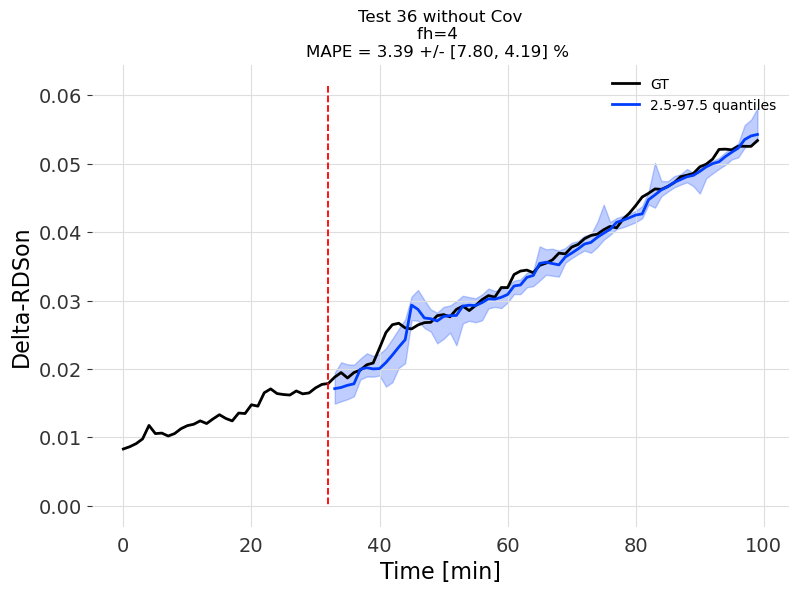

In [32]:
#Then, the results are being plotted
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
#Plot the Ground-Truth (GT) vector according to the test number being used
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")
#Transform the predictions values using the transformer used to normalize the test
transformer_A.inverse_transform(predictions_33[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
#Plot a vertical line to mark the first iteration
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [(MAX_VAL * 1.15), (MAX_VAL / 2), 0.000], 'r',
         linestyle='dashed')
#Setup labels for the axis, legend and title for the plot
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_33, MAPE_33_q25, MAPE_33_q975))
plt.legend()
plt.show()

## Now use 50% of the data as training set (Figure 7, T36 TFT 4 @ 50%)

In [33]:
#Now the process is repeated but for a different start point (e.g. 49)
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 49
predictions_50 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=49, train=50, val=50
k=53, train=54, val=46
k=57, train=58, val=42
k=61, train=62, val=38
k=65, train=66, val=34
k=69, train=70, val=30
k=73, train=74, val=26
k=77, train=78, val=22
k=81, train=82, val=18
k=85, train=86, val=14
k=89, train=90, val=10
k=93, train=94, val=6
k=97, train=98, val=2
--------------------------------------------------------------------
Elapsed time = 15 minutes
Len predictions: 52


In [34]:
#Now the MAPE is computed for the mean, lower and upper quantiles
_, validation_series = test_A_transformed.split_after(training_cutoff)
MAPE_50 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_50))
pred50_q25 = predictions_50[0:len(validation_series)].quantile(0.025)
pred50_q975 = predictions_50[0:len(validation_series)].quantile(0.975)
MAPE_50_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred50_q25))
MAPE_50_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred50_q975))
print("MAPE @50% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_50, MAPE_50_q25, MAPE_50_q975))

MAPE @50% = 2.32 +/- [5.45, 2.49]


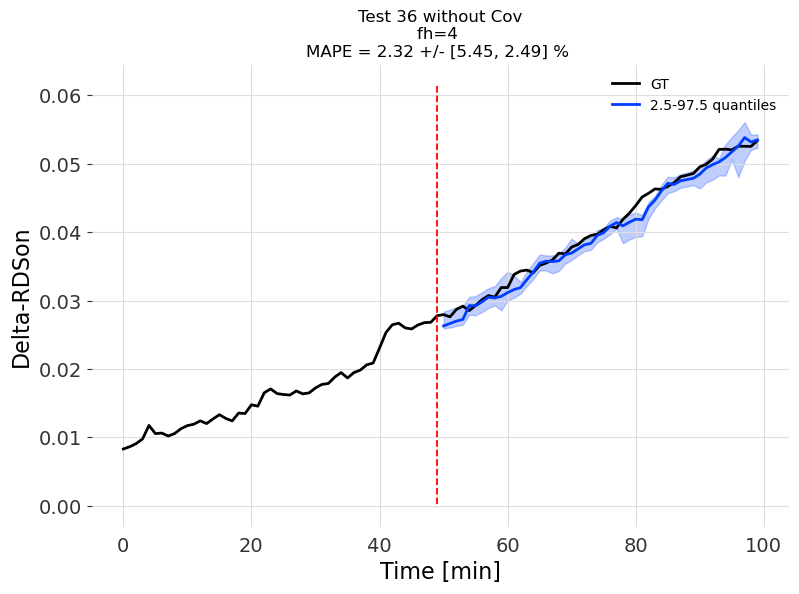

In [35]:
#Next, the results are plotted
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_50[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_50, MAPE_50_q25, MAPE_50_q975))
plt.legend()
plt.show()

## Now use 75% of the data as training set (Figure 7, T36 TFT 4 @ 75%)

In [36]:
#Now the process is repeated but for a different start point (e.g. 74)
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 74
predictions_75 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=74, train=75, val=25
k=78, train=79, val=21
k=82, train=83, val=17
k=86, train=87, val=13
k=90, train=91, val=9
k=94, train=95, val=5
k=98, train=99, val=1
--------------------------------------------------------------------
Elapsed time = 12 minutes
Len predictions: 28


In [37]:
#Now the MAPE is computed for the mean, lower and upper quantiles
_, validation_series = test_A_transformed.split_after(training_cutoff)
MAPE_75 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_75))
pred75_q25 = predictions_75[0:len(validation_series)].quantile(0.025)
pred75_q975 = predictions_75[0:len(validation_series)].quantile(0.975)
MAPE_75_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred75_q25))
MAPE_75_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred75_q975))
print("MAPE @75% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_75, MAPE_75_q25, MAPE_75_q975))

MAPE @75% = 1.92 +/- [4.21, 2.26]


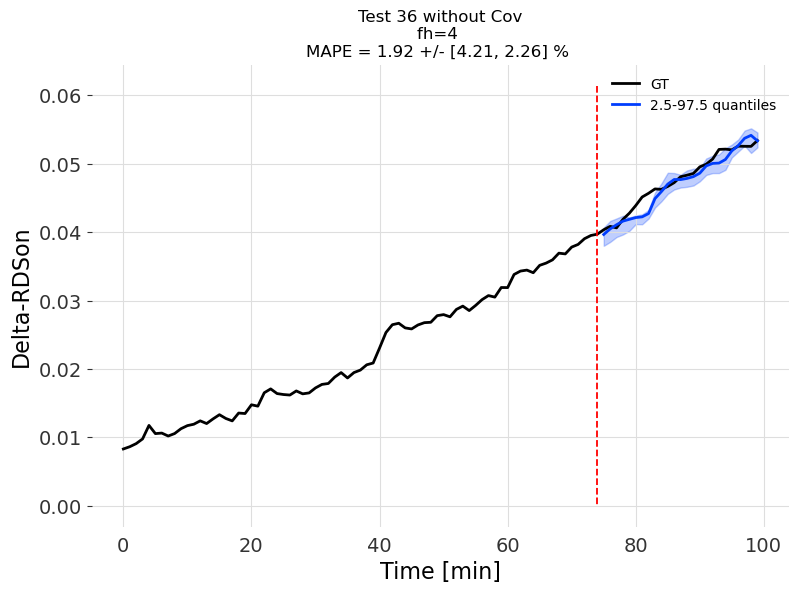

In [38]:
#Then, the results are being plotted
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_75[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_75, MAPE_75_q25, MAPE_75_q975))
plt.legend()
plt.show()

# Test #12

In [39]:
#Now, the selected test is switched and the whole process is repeated.
SELECTOR = 2
if SELECTOR == 1:
    test_A_transformed = test_36_transformed
    transformer_A = transformer_36
    test_No = "36"
elif SELECTOR == 2:
    test_A_transformed = test_12_transformed
    transformer_A = transformer_12
    test_No = "12"
elif SELECTOR == 3:
    test_A_transformed = test_11_transformed
    test_A_transformed_trimmed = test_11_transformed_trimmed
    transformer_A = transformer_11
    test_No = "11"
else:
    test_A_transformed = test_09_transformed
    test_A_transformed_trimmed = test_09_transformed_trimmed
    transformer_A = transformer_09
    test_No = "09"
print(test_No)

12


## Forecasting using the 33% of the data as training (Table 3 in the paper)

In [26]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 32
predictions_33 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=32, train=33, val=67
k=36, train=37, val=63
k=40, train=41, val=59
k=44, train=45, val=55
k=48, train=49, val=51
k=52, train=53, val=47
k=56, train=57, val=43
k=60, train=61, val=39
k=64, train=65, val=35
k=68, train=69, val=31
k=72, train=73, val=27
k=76, train=77, val=23
k=80, train=81, val=19
k=84, train=85, val=15
k=88, train=89, val=11
k=92, train=93, val=7
k=96, train=97, val=3
--------------------------------------------------------------------
Elapsed time = 17 minutes
Len predictions: 68


In [27]:
_, validation_series = test_A_transformed.split_after(training_cutoff)
MAPE_33 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_33))
pred33_q25 = predictions_33[0:len(validation_series)].quantile(0.025)
pred33_q975 = predictions_33[0:len(validation_series)].quantile(0.975)
MAPE_33_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred33_q25))
MAPE_33_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred33_q975))
print("MAPE @33% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_33, MAPE_33_q25, MAPE_33_q975))

MAPE @33% = 11.12 +/- [20.26, 14.49]


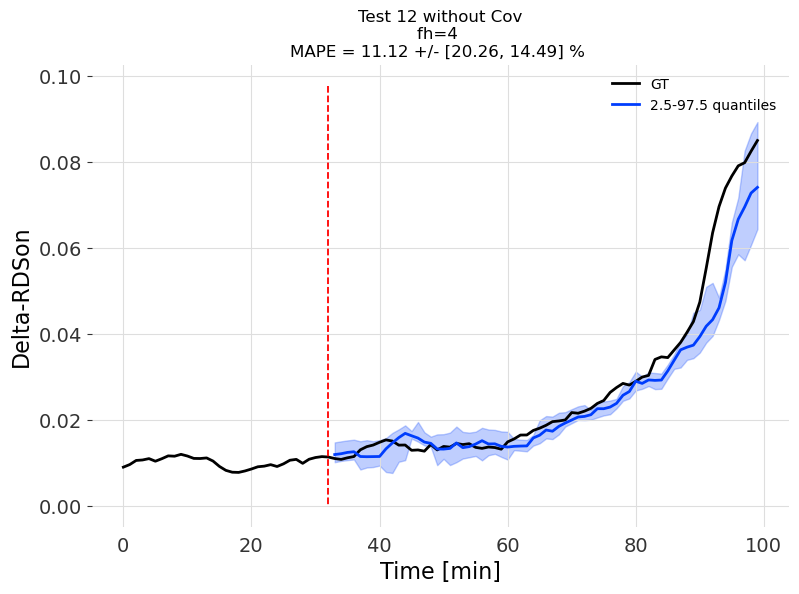

In [28]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_33[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_33, MAPE_33_q25, MAPE_33_q975))
plt.legend()
plt.show()

## Forecasting using the 50% of the data as training (Figure 7, T12 TFT 4 @ 50%)

In [40]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 49
predictions_50 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=49, train=50, val=50
k=53, train=54, val=46
k=57, train=58, val=42
k=61, train=62, val=38
k=65, train=66, val=34
k=69, train=70, val=30
k=73, train=74, val=26
k=77, train=78, val=22
k=81, train=82, val=18
k=85, train=86, val=14
k=89, train=90, val=10
k=93, train=94, val=6
k=97, train=98, val=2
--------------------------------------------------------------------
Elapsed time = 17 minutes
Len predictions: 52


In [41]:
_, validation_series = test_A_transformed.split_after(training_cutoff)
MAPE_50 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_50))
pred50_q25 = predictions_50[0:len(validation_series)].quantile(0.025)
pred50_q975 = predictions_50[0:len(validation_series)].quantile(0.975)
MAPE_50_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred50_q25))
MAPE_50_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred50_q975))
print("MAPE @50% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_50, MAPE_50_q25, MAPE_50_q975))

MAPE @50% = 12.28 +/- [19.65, 9.23]


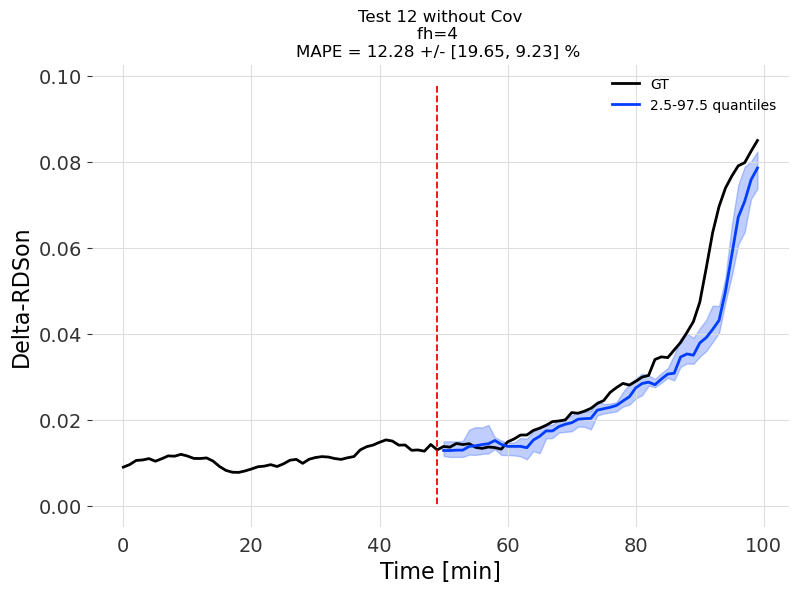

In [42]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_50[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_50, MAPE_50_q25, MAPE_50_q975))
plt.legend()
plt.show()

## Forecasting using the 75% of the data as training (Figure 7, T12 TFT 4 @ 75%)

In [43]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 74
predictions_75 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=74, train=75, val=25
k=78, train=79, val=21
k=82, train=83, val=17
k=86, train=87, val=13
k=90, train=91, val=9
k=94, train=95, val=5
k=98, train=99, val=1
--------------------------------------------------------------------
Elapsed time = 11 minutes
Len predictions: 28


In [44]:
_, validation_series = test_A_transformed.split_after(training_cutoff)
MAPE_75 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_75))
pred75_q25 = predictions_75[0:len(validation_series)].quantile(0.025)
pred75_q975 = predictions_75[0:len(validation_series)].quantile(0.975)
MAPE_75_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred75_q25))
MAPE_75_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred75_q975))
print("MAPE @75% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_75, MAPE_75_q25, MAPE_75_q975))

MAPE @75% = 14.76 +/- [22.61, 8.68]


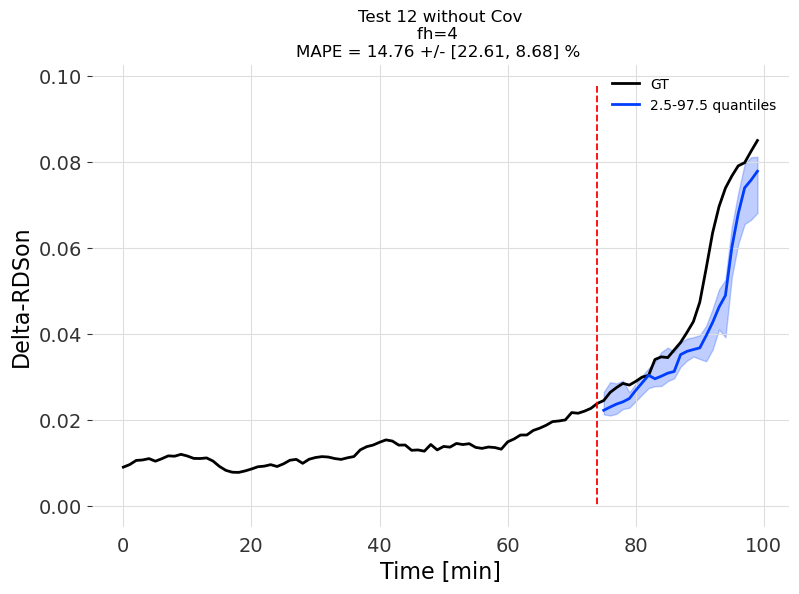

In [45]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_75[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_75, MAPE_75_q25, MAPE_75_q975))
plt.legend()
plt.show()

# Test #11

In [46]:
SELECTOR = 3
if SELECTOR == 1:
    test_A_transformed = test_36_transformed
    transformer_A = transformer_36
    test_No = "36"
elif SELECTOR == 2:
    test_A_transformed = test_12_transformed
    transformer_A = transformer_12
    test_No = "12"
elif SELECTOR == 3:
    test_A_transformed = test_11_transformed
    test_A_transformed_trimmed = test_11_transformed_trimmed
    transformer_A = transformer_11
    test_No = "11"
else:
    test_A_transformed = test_09_transformed
    test_A_transformed_trimmed = test_09_transformed_trimmed
    transformer_A = transformer_09
    test_No = "09"
print(test_No)

11


## Forecasting using the 33% of the data as training (Table 3 in the paper)

In [22]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 32
predictions_33 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=32, train=33, val=67
k=36, train=37, val=63
k=40, train=41, val=59
k=44, train=45, val=55
k=48, train=49, val=51
k=52, train=53, val=47
k=56, train=57, val=43
k=60, train=61, val=39
k=64, train=65, val=35
k=68, train=69, val=31
k=72, train=73, val=27
k=76, train=77, val=23
k=80, train=81, val=19
k=84, train=85, val=15
k=88, train=89, val=11
k=92, train=93, val=7
k=96, train=97, val=3
--------------------------------------------------------------------
Elapsed time = 17 minutes
Len predictions: 68


In [23]:
_, validation_series = test_A_transformed_trimmed.split_after(training_cutoff)
MAPE_33 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_33))
pred33_q25 = predictions_33[0:len(validation_series)].quantile(0.025)
pred33_q975 = predictions_33[0:len(validation_series)].quantile(0.975)
MAPE_33_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred33_q25))
MAPE_33_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred33_q975))
print("MAPE @33% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_33, MAPE_33_q25, MAPE_33_q975))

MAPE @33% = 10.55 +/- [14.63, 10.95]


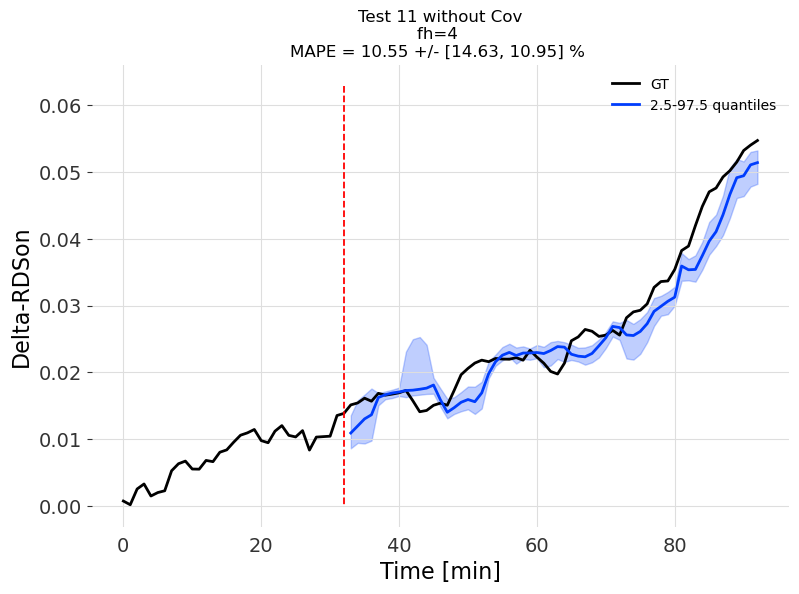

In [24]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_33[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_33, MAPE_33_q25, MAPE_33_q975))
plt.legend()
plt.show()

## Forecasting using the 50% of the data as training (Figure 7, T11 TFT 4 @ 50%)

In [47]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 49
predictions_50 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=49, train=50, val=50
k=53, train=54, val=46
k=57, train=58, val=42
k=61, train=62, val=38
k=65, train=66, val=34
k=69, train=70, val=30
k=73, train=74, val=26
k=77, train=78, val=22
k=81, train=82, val=18
k=85, train=86, val=14
k=89, train=90, val=10
k=93, train=94, val=6
k=97, train=98, val=2
--------------------------------------------------------------------
Elapsed time = 17 minutes
Len predictions: 52


In [48]:
_, validation_series = test_A_transformed_trimmed.split_after(training_cutoff)
MAPE_50 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_50))
pred50_q25 = predictions_50[0:len(validation_series)].quantile(0.025)
pred50_q975 = predictions_50[0:len(validation_series)].quantile(0.975)
MAPE_50_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred50_q25))
MAPE_50_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred50_q975))
print("MAPE @50% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_50, MAPE_50_q25, MAPE_50_q975))

MAPE @50% = 10.60 +/- [14.56, 7.46]


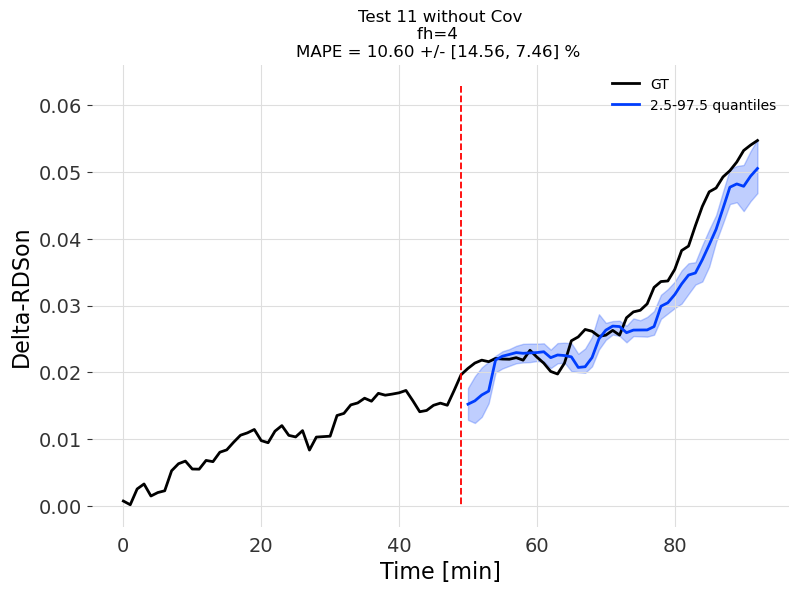

In [49]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_50[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_50, MAPE_50_q25, MAPE_50_q975))
plt.legend()
plt.show()

## Forecasting using the 75% of the data as training (Figure 7, T11 TFT 4 @ 75%)

In [50]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 74
predictions_75 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=74, train=75, val=25
k=78, train=79, val=21
k=82, train=83, val=17
k=86, train=87, val=13
k=90, train=91, val=9
k=94, train=95, val=5
k=98, train=99, val=1
--------------------------------------------------------------------
Elapsed time = 11 minutes
Len predictions: 28


In [51]:
_, validation_series = test_A_transformed_trimmed.split_after(training_cutoff)
MAPE_75 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_75))
pred75_q25 = predictions_75[0:len(validation_series)].quantile(0.025)
pred75_q975 = predictions_75[0:len(validation_series)].quantile(0.975)
MAPE_75_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred75_q25))
MAPE_75_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred75_q975))
print("MAPE @75% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_75, MAPE_75_q25, MAPE_75_q975))

MAPE @75% = 10.93 +/- [15.30, 6.47]


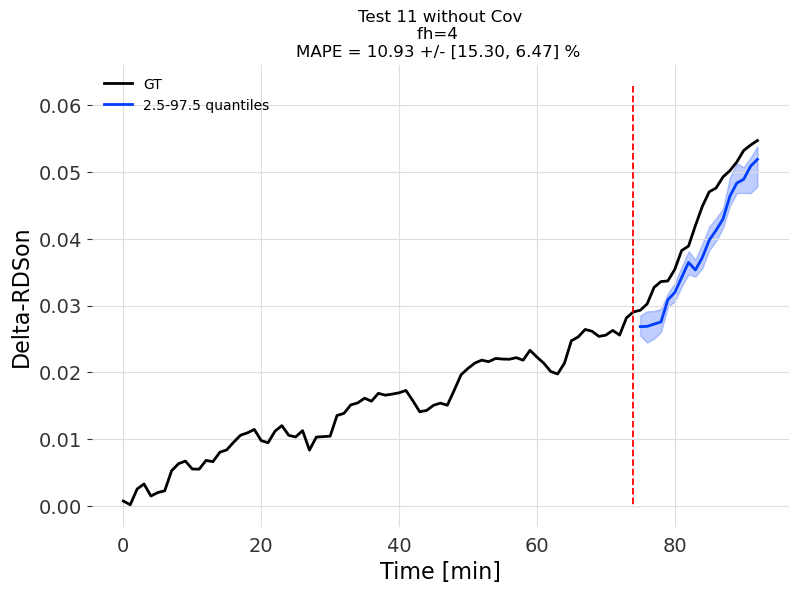

In [52]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_75[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_75, MAPE_75_q25, MAPE_75_q975))
plt.legend()
plt.show()

# Test #09

In [12]:
# Test Selection
SELECTOR = 4
if SELECTOR == 1:
    test_A_transformed = test_36_transformed
    transformer_A = transformer_36
    test_No = "36"
elif SELECTOR == 2:
    test_A_transformed = test_12_transformed
    transformer_A = transformer_12
    test_No = "12"
elif SELECTOR == 3:
    test_A_transformed = test_11_transformed
    test_A_transformed_trimmed = test_11_transformed_trimmed
    transformer_A = transformer_11
    test_No = "11"
else:
    test_A_transformed = test_09_transformed
    test_A_transformed_trimmed = test_09_transformed_trimmed
    transformer_A = transformer_09
    test_No = "09"
print(test_No)

09


## Forecasting using the 33% of the data as training (Table 3 in the paper)

In [18]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 32
predictions_33 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=32, train=33, val=67
k=36, train=37, val=63
k=40, train=41, val=59
k=44, train=45, val=55
k=48, train=49, val=51
k=52, train=53, val=47
k=56, train=57, val=43
k=60, train=61, val=39
k=64, train=65, val=35
k=68, train=69, val=31
k=72, train=73, val=27
k=76, train=77, val=23
k=80, train=81, val=19
k=84, train=85, val=15
k=88, train=89, val=11
k=92, train=93, val=7
k=96, train=97, val=3
--------------------------------------------------------------------
Elapsed time = 17 minutes
Len predictions: 68


In [19]:
_, validation_series = test_A_transformed_trimmed.split_after(training_cutoff)
MAPE_33 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_33))
pred33_q25 = predictions_33[0:len(validation_series)].quantile(0.025)
pred33_q975 = predictions_33[0:len(validation_series)].quantile(0.975)
MAPE_33_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred33_q25))
MAPE_33_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred33_q975))
print("MAPE @33% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_33, MAPE_33_q25, MAPE_33_q975))

MAPE @33% = 5.33 +/- [11.03, 6.13]


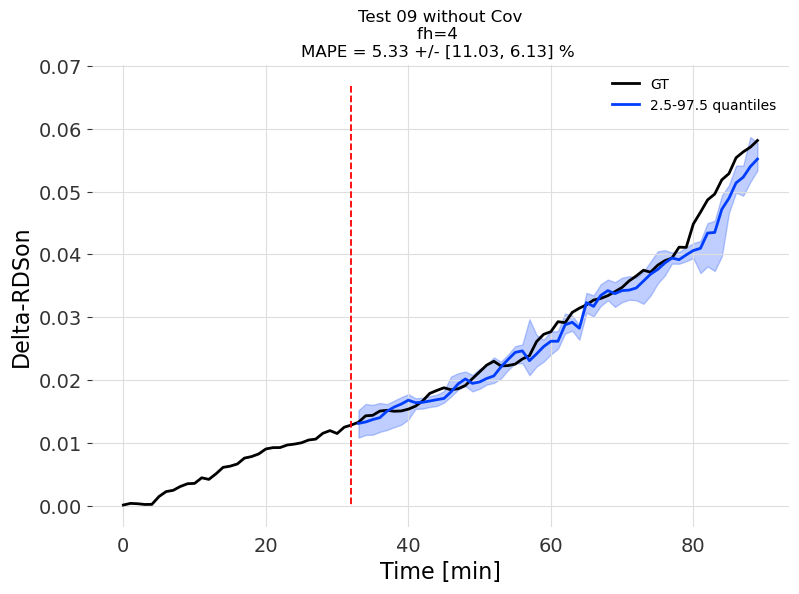

In [20]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_33[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_33, MAPE_33_q25, MAPE_33_q975))
plt.legend()
plt.show()

## Forecasting using the 50% of the data as training (Figure 7, T09 TFT 4 @ 50%)

In [13]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 49
predictions_50 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=49, train=50, val=50
k=53, train=54, val=46
k=57, train=58, val=42
k=61, train=62, val=38
k=65, train=66, val=34
k=69, train=70, val=30
k=73, train=74, val=26
k=77, train=78, val=22
k=81, train=82, val=18
k=85, train=86, val=14
k=89, train=90, val=10
k=93, train=94, val=6
k=97, train=98, val=2
--------------------------------------------------------------------
Elapsed time = 15 minutes
Len predictions: 52


In [14]:
_, validation_series = test_A_transformed_trimmed.split_after(training_cutoff)
MAPE_50 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_50))
pred50_q25 = predictions_50[0:len(validation_series)].quantile(0.025)
pred50_q975 = predictions_50[0:len(validation_series)].quantile(0.975)
MAPE_50_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred50_q25))
MAPE_50_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred50_q975))
print("MAPE @50% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_50, MAPE_50_q25, MAPE_50_q975))

MAPE @50% = 6.17 +/- [13.14, 4.47]


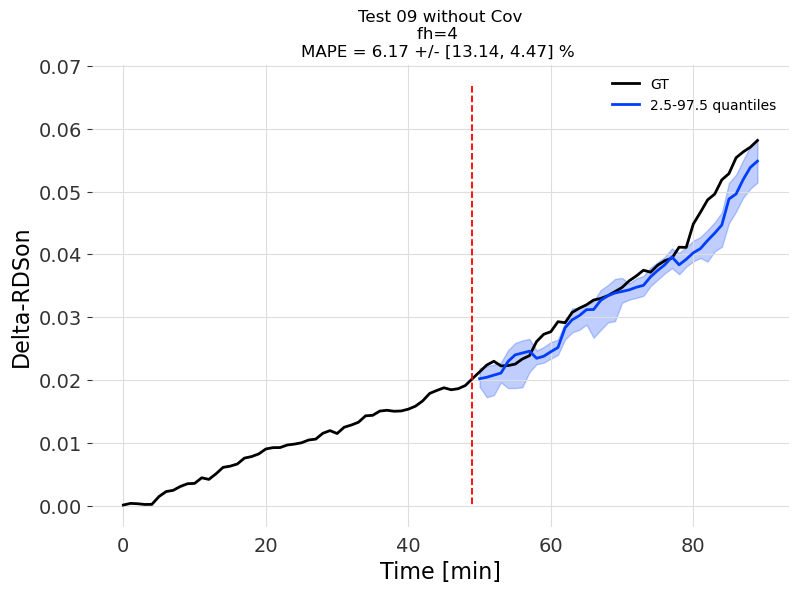

In [15]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_50[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_50, MAPE_50_q25, MAPE_50_q975))
plt.legend()
plt.show()

## Forecasting using the 75% of the data as training (Figure 7, T09 TFT 4 @ 75%)

In [16]:
#Define the TFT
test_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hiddenSize,
    lstm_layers=lstms,
    num_attention_heads=attn_heads,
    dropout=0.1,
    batch_size=16,
    n_epochs=400,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
)
training_cutoff = 74
predictions_75 = pred_n_tr(model=test_model, fh=forecast_horizon,
                           test_transformed=test_A_transformed, split_point=training_cutoff,
                           covs=covariates_transformed)

k=74, train=75, val=25
k=78, train=79, val=21
k=82, train=83, val=17
k=86, train=87, val=13
k=90, train=91, val=9
k=94, train=95, val=5
k=98, train=99, val=1
--------------------------------------------------------------------
Elapsed time = 10 minutes
Len predictions: 28


In [17]:
_, validation_series = test_A_transformed_trimmed.split_after(training_cutoff)
MAPE_75 = mape(actual_series=transformer_A.inverse_transform(validation_series),
               pred_series=transformer_A.inverse_transform(predictions_75))
pred75_q25 = predictions_75[0:len(validation_series)].quantile(0.025)
pred75_q975 = predictions_75[0:len(validation_series)].quantile(0.975)
MAPE_75_q25 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                   pred_series=transformer_A.inverse_transform(pred75_q25))
MAPE_75_q975 = mape(actual_series=transformer_A.inverse_transform(validation_series),
                    pred_series=transformer_A.inverse_transform(pred75_q975))
print("MAPE @75% = {:.2f} +/- [{:.2f}, {:.2f}]".format(MAPE_75, MAPE_75_q25, MAPE_75_q975))

MAPE @75% = 6.01 +/- [11.86, 3.43]


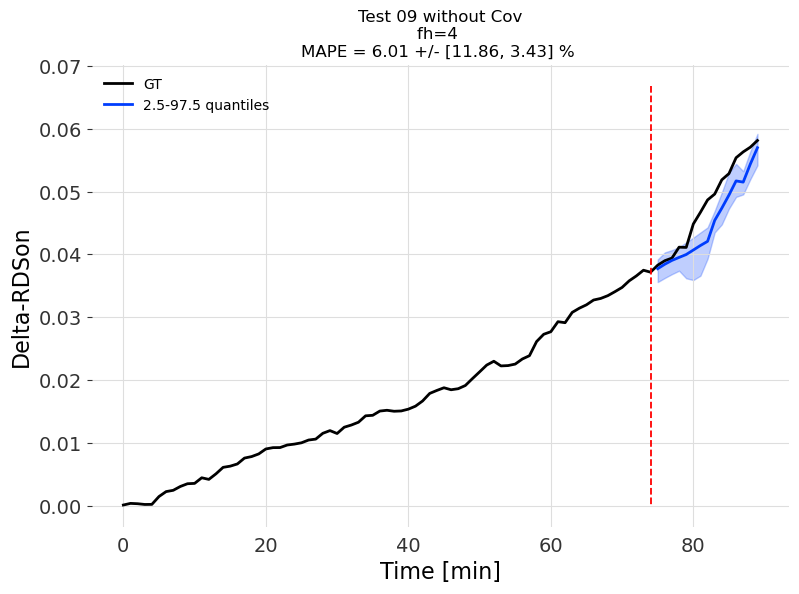

In [18]:
#plotting
testName = "Test {} without Cov\nfh={}".format(test_No, forecast_horizon)
plt.figure(figsize=figsize)
if SELECTOR == 1:
    MAX_VAL = max(test36_series.values())
    MAX_VAL = MAX_VAL[0]
    test36_series.plot(label="GT")
elif SELECTOR == 2:
    MAX_VAL = max(test12_series.values())
    MAX_VAL = MAX_VAL[0]
    test12_series.plot(label="GT")
elif SELECTOR == 3:
    MAX_VAL = max(test11_series.values())
    MAX_VAL = MAX_VAL[0]
    test11_series[0:93].plot(label="GT")
else:
    MAX_VAL = max(test09_series.values())
    MAX_VAL = MAX_VAL[0]
    test09_series[0:90].plot(label="GT")

transformer_A.inverse_transform(predictions_75[0:len(validation_series)]).plot(low_quantile=0.025, high_quantile=0.975,
                                                                               label="2.5-97.5 quantiles")
plt.plot([training_cutoff, training_cutoff, training_cutoff],
         [MAX_VAL * 1.15, MAX_VAL / 2, 0.000], 'r',
         linestyle='dashed')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlabel('Time [min]', fontsize=16)
plt.ylabel('Delta-RDSon', fontsize=16)
plt.title("{} \nMAPE = {:.2f} +/- [{:.2f}, {:.2f}] % ".format(testName, MAPE_75, MAPE_75_q25, MAPE_75_q975))
plt.legend()
plt.show()

In [48]:
# To complete the results at forecasting horizons of 1 and 2, change the fh variable and repeat.